# ParameterizedLibrary Feature Overview
This notebook provides a simple overview of the ParameterizedLibrary functionality of PySINDy. Jupyter notebook written by Zachary G. Nicolaou.

In [1]:
import matplotlib.pyplot as plt
from pysindy.utils import lorenz
import pysindy as ps
import numpy as np
from scipy.integrate import solve_ivp
from pysindy.utils import lorenz
import timeit

In [2]:
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

### Fit a parameterized logistic map
The logistic map
$$ x_{n+1} = r x_n(1-x_n)$$
depends on one parameter $r$. 

The behavior is chaotic for r>3.6

In [3]:
num=1000
N=1000
N_drop=500
r0=3.5
rs=r0+np.arange(num)/num*(4-r0)
xss=[]
for r in rs:
    xs=[]
    x=0.5
    for n in range(N+N_drop):
        if n>=N_drop:
            xs=xs+[x]
        x=r*x*(1-x)
    xss=xss+[xs]

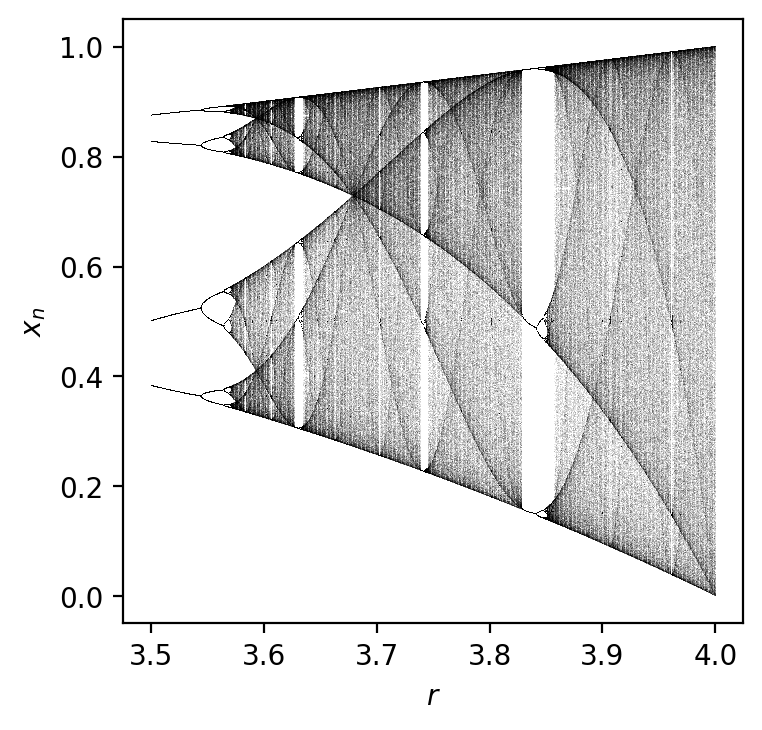

In [4]:
plt.figure(figsize=(4,4),dpi=200)
for ind in range(num):
    plt.plot(np.ones(N)*rs[ind],xss[ind], ',', alpha=0.1, c='black', rasterized=True)
plt.xlabel('$r$')
plt.ylabel('$x_n$')
plt.savefig('logistic.pdf')
plt.show()

We fit a parSINDy model from four trajectories with differing values of $r$

In [5]:
N=1000
N_drop=500

rs=[3.6,3.7,3.8,3.9]
xss=[]
for r in rs:
    xs=[]
    x=0.5
    for n in range(N+N_drop):
        if n>=N_drop:
            xs=xs+[x]
        x=r*x*(1-x)
    xss=xss+[np.array(xs)]

In [6]:
feature_lib=ps.PolynomialLibrary(degree=3,include_bias=True)
parameter_lib=ps.PolynomialLibrary(degree=1,include_bias=True)
lib=ps.ParameterizedLibrary(feature_library=feature_lib,parameter_library=parameter_lib,num_features=1,num_parameters=1)
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'r'], discrete_time=True)
model.fit(xss, u=[np.ones(N)*rs[ind] for ind in range(len(rs))], multiple_trajectories=True)
model.print()


(x)[k+1] = 1.000 r[k] x[k] + -1.000 r[k] x[k]^2


### Fit a parameterized Lorenz model
The Lorenz equations
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z. $$
depend on 3 parameters, $\sigma$, $\rho$, and $\beta$. We generate 10 trajectories with different parameter values.

In [7]:
start=timeit.default_timer()

dt = .002
num_trajectories=5
scalesigma=1
scalerho=1
scalebeta=1

np.random.seed(100)
sigmas=10 + scalesigma*(np.random.random(num_trajectories)-0.5)
rhos=28*np.ones(num_trajectories) + scalerho*(np.random.random(num_trajectories)-0.5)
betas=2.66667*np.ones(num_trajectories) + scalebeta*(np.random.random(num_trajectories)-0.5)
x_trains=[]
t_trains=[]

for i in range(len(sigmas)):
    t_train = np.arange(0, 10, dt)
    x0_train = [-8, 8, 27]
    t_train_span = (t_train[0], t_train[-1])
    x_train = solve_ivp(lorenz, t_train_span, x0_train, args=(sigmas[i],betas[i],rhos[i]),
                    t_eval=t_train, **integrator_keywords).y.T
    x_trains=x_trains+[x_train]
    t_trains=t_trains+[t_train]

stop=timeit.default_timer()
print(stop-start)

0.6917737694457173


Fitting any one trajectory gives the equation corresponding to a specfic set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [8]:
lib=ps.PolynomialLibrary()
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains[-1], t=dt)
model.print()
print([sigmas[-1],rhos[-1],betas[-1]])
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -9.504 x + 9.504 y
(y)' = 28.068 x + -0.999 y + -1.000 x z
(z)' = -2.386 z + 1.000 x y
[9.504718856190973, 28.07509332942725, 2.3863674926249923]
['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2']


We use the control input of ps.model to specify the parameter values, and fit a SINDy model with multiple trajectories.

Create list of control inputs corresponding to the parameters. The control inputs have the same shape as the data, but are constant across the temporal grid.

In [9]:
sigmas_timeseries=np.array(sigmas)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
rhos_timeseries=np.array(rhos)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
betas_timeseries=np.array(betas)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
u_trains=[np.concatenate([np.transpose([sigmas_timeseries[i]]),np.transpose([rhos_timeseries[i]]),np.transpose([betas_timeseries[i]])],axis=1) for i in range(num_trajectories)]

Fitting a PolynomialLibrary with multiple_trajectories=True gives the correct model, but note that the same library functions are applied to the input features and the control input.

In [10]:
lib=ps.PolynomialLibrary()
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -1.000 x sigma + 1.000 y sigma
(y)' = -0.999 y + -1.000 x z + 1.000 x rho
(z)' = 1.000 x y + -1.000 z beta
['1', 'x', 'y', 'z', 'sigma', 'rho', 'beta', 'x^2', 'x y', 'x z', 'x sigma', 'x rho', 'x beta', 'y^2', 'y z', 'y sigma', 'y rho', 'y beta', 'z^2', 'z sigma', 'z rho', 'z beta', 'sigma^2', 'sigma rho', 'sigma beta', 'rho^2', 'rho beta', 'beta^2']


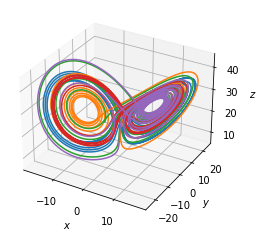

In [11]:
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection='3d')

for i in range(num_trajectories):
    ax.plot(x_trains[i][:,0],x_trains[i][:,1],x_trains[i][:,2])
    
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.savefig('lorenz.pdf')
plt.show()

The ParameterizedLibrary enables different libraries to be applied to the control input and input features. In this case, the result is the same, but different libraries are required for the PDE case, as shown below.

In [12]:
feature_library=ps.PolynomialLibrary(degree=4)
parameter_library=ps.PolynomialLibrary(degree=1)
lib=ps.ParameterizedLibrary(feature_library=feature_library,parameter_library=parameter_library, num_parameters=3)
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -1.000 sigma x + 1.000 sigma y
(y)' = -0.999 1 y + -1.000 1 x z + 1.000 rho x
(z)' = 1.000 1 x y + -1.000 beta z
['1 1', '1 x', '1 y', '1 z', '1 x^2', '1 x y', '1 x z', '1 y^2', '1 y z', '1 z^2', '1 x^3', '1 x^2 y', '1 x^2 z', '1 x y^2', '1 x y z', '1 x z^2', '1 y^3', '1 y^2 z', '1 y z^2', '1 z^3', '1 x^4', '1 x^3 y', '1 x^3 z', '1 x^2 y^2', '1 x^2 y z', '1 x^2 z^2', '1 x y^3', '1 x y^2 z', '1 x y z^2', '1 x z^3', '1 y^4', '1 y^3 z', '1 y^2 z^2', '1 y z^3', '1 z^4', 'sigma 1', 'sigma x', 'sigma y', 'sigma z', 'sigma x^2', 'sigma x y', 'sigma x z', 'sigma y^2', 'sigma y z', 'sigma z^2', 'sigma x^3', 'sigma x^2 y', 'sigma x^2 z', 'sigma x y^2', 'sigma x y z', 'sigma x z^2', 'sigma y^3', 'sigma y^2 z', 'sigma y z^2', 'sigma z^3', 'sigma x^4', 'sigma x^3 y', 'sigma x^3 z', 'sigma x^2 y^2', 'sigma x^2 y z', 'sigma x^2 z^2', 'sigma x y^3', 'sigma x y^2 z', 'sigma x y z^2', 'sigma x z^3', 'sigma y^4', 'sigma y^3 z', 'sigma y^2 z^2', 'sigma y z^3', 'sigma z^4', 'rho 1', 'rho x', 'rho y'

/home/zackn/.conda/envs/pysindy_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.00376e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/zackn/.conda/envs/pysindy_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.00376e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/zackn/.conda/envs/pysindy_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.00376e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


### Fit a parameterized complex Ginzburg-Landau equation
The complex Ginzburg-Landau equation
$$ \dot{A} = A + (1+ib)\nabla^2 A - (1-ic)|A|^2A$$
describes the evolution of the mode amplitude $A$ for pattern formation in a long-wavelength, supercritical Hopf bifurcation. It depends on two parameters $b$ and $c$. We generate 4 trajectories with different values of the parameters. (Note: this will take 5 minutes)

In [13]:
nx=128
ny=128
N=nx*ny
L=16
t1=1e2
t3=9e1
dt=1e-1
nt=int((t1-t3)/dt)
def cgle(t, Z, b, c):
    Zxxr=ps.SpectralDerivative(d=2,axis=0)._differentiate(np.real(Z).reshape((nx,ny)),1.0/nx)
    Zyyr=ps.SpectralDerivative(d=2,axis=1)._differentiate(np.real(Z).reshape((nx,ny)),1.0/ny)
    Zxxi=ps.SpectralDerivative(d=2,axis=0)._differentiate(np.imag(Z).reshape((nx,ny)),1.0/nx)
    Zyyi=ps.SpectralDerivative(d=2,axis=1)._differentiate(np.imag(Z).reshape((nx,ny)),1.0/ny)
    lap=(Zxxr+1j*Zxxi+Zyyr+1j*Zyyi).reshape(N)    
    return Z - (1-1j*c)*Z*Z*Z.conjugate() + (1+1j*b)*lap/(2*np.pi*L)**2


spatial_grid=np.zeros((nx,ny,2))
spatial_grid[:,:,0]=(np.arange(nx)-nx//2)[:,np.newaxis]*2*np.pi*L/nx
spatial_grid[:,:,1]=(np.arange(nx)-nx//2)[np.newaxis,:]*2*np.pi*L/nx
spatiotemporal_grid=np.zeros((nx,ny,100,3))
spatiotemporal_grid[:,:,:,:2]=spatial_grid[:,:,np.newaxis,:]
spatiotemporal_grid[:,:,:,2]=dt*np.arange(100)

In [14]:
bs=[2.0,2.0,0.5,1.0]
cs=[1.0,0.75,0.5,0.75]
scales=[1e-1,1e-1,1e-1,1e0]
scales2=[1e-2,1e-2,1e0,1e-2]

xs=[]
for i in range(len(bs)):
    b=bs[i]
    c=cs[i]
    scale0=scales[i]
    scale2=scales2[i]
    start=timeit.default_timer()

    ks=np.arange(-2,3)
    phase_init=np.zeros((nx,ny),dtype=np.complex128)+1
    kx=2
    ky=2
    phase_init = phase_init + scale2*(np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) - 1)

    np.random.seed(100)
    for kx in ks:
        for ky in ks:
            if not (kx==0 and ky==0):
                scale=scale0/(kx**2+ky**2)**0.5
                phase_init += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) 
    
    phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
    phase=phase_init.reshape(N)
    times=[]
    dt1=dt/1000
    for n in range(int(t1/dt)):
        t=n*dt
        print('%.1f'%(t),end='\r')
        sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
        times.append(sol.t)
        dt1=np.mean(np.diff(sol.t))
        phase=sol.y[:,-1]
        phases[n] = phase

    stop=timeit.default_timer()
    print(stop-start)
    x=np.zeros((nx,ny,nt,2))
    x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
    x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
    xs.append(x)
    
#Create list of control inputs corresponding to the parameters. 
#The control inputs have the same shape as the data, 
#but are constant across the spatiotemporal grid.
us=[]
for i in range(4):
    b=bs[i]
    c=cs[i]
    u=np.zeros(np.concatenate([xs[0].shape[:-1],[2]]))
    u[:,:,:,0]=b
    u[:,:,:,1]=c
    us.append(u)

39.80192827153951
41.82792823668569
29.05546457786113
28.89211461879313


Depending on the parameter values and initial conditions, the system exhibits different dynamical phases.

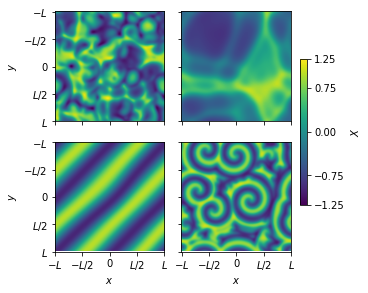

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig,axs=plt.subplots(2,2,figsize=(5,4), constrained_layout=True)

for i in range(len(xs)):
    plt.subplot(2,2,i+1)
    pl=plt.imshow(xs[i][:,:,-1,0],vmin=-1.25,vmax=1.25)
    plt.gca().set_xticks([0,32,64,96,128])
    plt.gca().set_xticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    plt.gca().set_yticks([0,32,64,96,128])
    plt.gca().set_yticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    if i==2 or i==3:
        plt.xlabel('$x$')
    else:
        plt.gca().set_xticklabels([])
    if i==0 or i==2:
        plt.ylabel('$y$')
    else:
        plt.gca().set_yticklabels([])
    
cbar=plt.colorbar(pl,ax=axs[:,1],orientation="vertical",ticks=[-1.25,-0.75,0.00,0.75,1.25],label='$X$',shrink=0.6)
plt.savefig('cgle.pdf')
plt.show()


Fitting any one trajectory gives the equation corresponding to a specfic set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [15]:
start=timeit.default_timer()
lib=ps.PDELibrary(library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x],derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,  lambda x,y:x+y+y])
lib.differentiation_method=ps.SpectralDerivative
lib.diff_kwargs={}
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['X', 'Y'])
model.fit(xs[-1],t=dt)
model.print()
stop=timeit.default_timer()
print(stop-start)

(X)' = 0.999 X + -0.999 XXX + -0.749 YYY + -0.749 XXY + -0.999 XYY + 0.999 X_22 + -0.999 Y_22 + 0.999 X_11 + -0.999 Y_11
(Y)' = 0.999 Y + 0.750 XXX + -0.999 YYY + -0.999 XXY + 0.750 XYY + 0.999 X_22 + 0.999 Y_22 + 0.999 X_11 + 0.999 Y_11
3.9390612952411175


Try a SINDy model with multiple trajectories using the ParameterizedLibrary. Use a PDELibrary for the feature_library with second-order derivatives and library functions that include the relevant cubic term. Use a PDELibrary for the parameter_library with zeroth-order derivatives and linear library functions. The fit is very good!

In [16]:
start=timeit.default_timer()
library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names)
library_functions=[lambda x:x]
function_names=[lambda x:x]
parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(x)' = 0.992 1 x + -0.990 1 xxx + -0.990 1 xyy + 1.023 1 x_22 + 0.121 1 y_22 + 1.022 1 x_11 + -0.990 b y_22 + -1.020 b y_11 + -1.000 c yyy + -1.000 c xxy + -0.196 c y_22
(y)' = 0.991 1 y + -0.989 1 yyy + -0.989 1 xxy + 1.024 1 y_22 + 1.022 1 y_11 + 1.022 b x_22 + 1.021 b x_11 + 1.000 c xxx + 1.000 c xyy
40.93224228359759
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


Modifying PDELibrary to accept spectral derivatives improves the fit a bit

In [17]:
start=timeit.default_timer()
library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names)
feature_lib.differentiation_method=ps.SpectralDerivative
feature_lib.diff_kwargs={}
library_functions=[lambda x:x]
function_names=[lambda x:x]
parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(x)' = 0.999 1 x + -0.999 1 xxx + -0.999 1 xyy + 0.999 1 x_22 + 0.999 1 x_11 + -0.999 b y_22 + -0.999 b y_11 + -0.999 c yyy + -0.999 c xxy
(y)' = 0.999 1 y + -0.999 1 yyy + -0.999 1 xxy + 0.999 1 y_22 + 0.999 1 y_11 + 0.999 b x_22 + 0.999 b x_11 + 0.999 c xxx + 0.999 c xyy
41.45306797046214
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


If we ensure the same domain cells are used in the feature library and the parameter library (by reseeding np.random), the WeakLibrary can be used with the ParameterLibrary. (In this case, the parameters need to be constants, so that the tensor product of two WeakLibrary corresponds to the correct weak features.) The fit is perfect and super fast!

In [18]:
start=timeit.default_timer()
np.random.seed(100)
library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=2,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names,K=500, H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
np.random.seed(100)
library_functions=[lambda x:x]
function_names=[lambda x:x]
parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,spatiotemporal_grid=spatiotemporal_grid,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True,K=500, H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(x)' = 1.000 1 x + -1.000 1 xxx + -1.000 1 xyy + 1.000 1 x_22 + 1.000 1 x_11 + -1.000 b y_22 + -1.000 b y_11 + -1.000 c yyy + -1.000 c xxy
(y)' = 1.000 1 y + -1.000 1 yyy + -1.000 1 xxy + 1.000 1 y_22 + 1.000 1 y_11 + 1.000 b x_22 + 1.000 b x_11 + 1.000 c xxx + 1.000 c xyy
9.555794385261834
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


### Effects of noise

Generate two new trajectories to for model testing

In [17]:
bs=[2.0, 1.5]
cs=[1.5, 1.0]
scales=[1e-1,1e-1]
scales2=[1e-2,1e-2]

xs_test=[]
for i in range(len(bs)):
    b=bs[i]
    c=cs[i]
    scale0=scales[i]
    scale2=scales2[i]
    start=timeit.default_timer()

    ks=np.arange(-2,3)
    phase_init=np.zeros((nx,ny),dtype=np.complex128)+1
    kx=2
    ky=2
    phase_init = phase_init + scale2*(np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) - 1)

    np.random.seed(100)
    for kx in ks:
        for ky in ks:
            if not (kx==0 and ky==0):
                scale=scale0/(kx**2+ky**2)**0.5
                phase_init += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) 
    
    phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
    phase=phase_init.reshape(N)
    times=[]
    dt1=dt/1000
    for n in range(int(t1/dt)):
        t=n*dt
        print('%.1f'%(t),end='\r')
        sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
        times.append(sol.t)
        dt1=np.mean(np.diff(sol.t))
        phase=sol.y[:,-1]
        phases[n] = phase

    stop=timeit.default_timer()
    print(stop-start)
    x=np.zeros((nx,ny,nt,2))
    x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
    x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
    xs_test.append(x)
    
#Create list of control inputs corresponding to the parameters. 
#The control inputs have the same shape as the data, 
#but are constant across the spatiotemporal grid.
us_test=[]
for i in range(2):
    b=bs[i]
    c=cs[i]
    u=np.zeros(np.concatenate([xs[0].shape[:-1],[2]]))
    u[:,:,:,0]=b
    u[:,:,:,1]=c
    us_test.append(u)


39.26745106372982
28.830548635683954


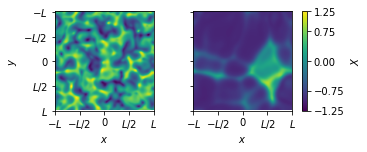

In [21]:
fig,axs=plt.subplots(2,1,figsize=(5,2), constrained_layout=True)

for i in range(len(xs_test)):
    plt.subplot(1,2,i+1)
    pl=plt.imshow(xs_test[i][:,:,-1,0],vmin=-1.25,vmax=1.25)
    plt.gca().set_xticks([0,32,64,96,128])
    plt.gca().set_xticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    plt.gca().set_yticks([0,32,64,96,128])
    plt.gca().set_yticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    if i==0 or i==1:
        plt.xlabel('$x$')
    else:
        plt.gca().set_xticklabels([])
    if i==0 or i==2:
        plt.ylabel('$y$')
    else:
        plt.gca().set_yticklabels([])
    
plt.colorbar(pl,orientation="vertical",ticks=[-1.25,-0.75,0.00,0.75,1.25],label='$X$')
plt.show()


Sweep fits with varying noise intensity

In [22]:
num=10
noisemin=-5
noisemax=-1
intensities=10**(noisemin+np.arange(num)/(num-1)*(noisemax-noisemin))

In [23]:
scores=[]
complexities=[]

for scale in intensities:
    print(scale)
    library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
    function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
    feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names)
    feature_lib.differentiation_method=ps.SpectralDerivative
    feature_lib.diff_kwargs={}
    library_functions=[lambda x:x]
    function_names=[lambda x:x]
    parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
    lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
    opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
    xs_noisy=[xs[i] + scale*np.random.normal(0,1,size=xs[i].shape) for i in range(len(xs))]
    model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
    model.fit(xs_noisy,u=us,t=dt,multiple_trajectories=True)

    scores=scores+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
    complexities=complexities+[model.complexity]


1e-05
2.782559402207126e-05
7.742636826811278e-05
0.00021544346900318823
0.0005994842503189409
0.0016681005372000592
0.004641588833612777
0.01291549665014884
0.03593813663804626


/home/zackn/pysindy/pysindy/optimizers/stlsq.py:183: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(


0.1


/home/zackn/pysindy/pysindy/optimizers/stlsq.py:183: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(


In [24]:
scores_weak=[]
complexities_weak=[]

for scale in intensities:
    print(scale)
    np.random.seed(100)
    library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
    function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
    feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=2,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names, K=500, H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
    np.random.seed(100)
    library_functions=[lambda x:x]
    function_names=[lambda x:x]
    parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,spatiotemporal_grid=spatiotemporal_grid,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True, K=500,H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
    lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
    opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
    xs_noisy=[xs[i] + scale*np.random.normal(0,1,size=xs[i].shape) for i in range(len(xs))]
    model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
    model.fit(xs_noisy,u=us,t=dt,multiple_trajectories=True)

    scores_weak=scores_weak+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
    complexities_weak=complexities_weak+[model.complexity]


1e-05
2.782559402207126e-05
7.742636826811278e-05
0.00021544346900318823
0.0005994842503189409
0.0016681005372000592
0.004641588833612777
0.01291549665014884
0.03593813663804626
0.1


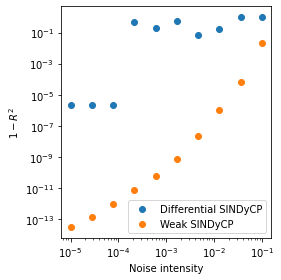

In [25]:
plt.figure(figsize=(4,4))
plt.scatter(intensities,1-np.array(scores), label='Differential SINDyCP')
plt.scatter(intensities,1-np.array(scores_weak), label='Weak SINDyCP')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Noise intensity')
plt.ylabel('$1-R^2$')
plt.legend()
plt.tight_layout()
plt.savefig('fig3.pdf')
plt.show()

### Higher-order parameter libraries will work with more trajectories

In [25]:
bs=np.random.normal(1.5,0.5,size=10)
cs=np.random.normal(1.0,0.25,size=10)
scales=[1e-1]*5+[1e0]*5

xs=[]
for i in range(len(bs)):
    b=bs[i]
    c=cs[i]
    scale0=scales[i]
    start=timeit.default_timer()

    ks=np.arange(-2,3)
    phase_init=np.zeros((nx,ny),dtype=np.complex128)+1
    np.random.seed(100)
    for kx in ks:
        for ky in ks:
            if not (kx==0 and ky==0):
                scale=scale0/(kx**2+ky**2)**0.5
                phase_init += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) 
    
    phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
    phase=phase_init.reshape(N)
    times=[]
    dt1=dt/1000
    for n in range(int(t1/dt)):
        t=n*dt
        print('%.1f'%(t),end='\r')
        sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
        times.append(sol.t)
        dt1=np.mean(np.diff(sol.t))
        phase=sol.y[:,-1]
        phases[n] = phase

    stop=timeit.default_timer()
    print(stop-start)
    x=np.zeros((nx,ny,nt,2))
    x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
    x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
    xs.append(x)
    
#Create list of control inputs corresponding to the parameters. 
#The control inputs have the same shape as the data, 
#but are constant across the spatiotemporal grid.
us=[]
for i in range(len(xs)):
    b=bs[i]
    c=cs[i]
    u=np.zeros(np.concatenate([xs[0].shape[:-1],[2]]))
    u[:,:,:,0]=b
    u[:,:,:,1]=c
    us.append(u)

29.57433824799955
29.417095648124814
29.59189985319972
29.385281738825142
42.55598279275
29.60605427995324
29.65141634643078
29.74732043314725
42.89683151803911
29.804340622387826


In [104]:
spatiotemporal_grid=np.zeros((nx,ny,100,3))
spatiotemporal_grid[:,:,:,:2]=spatial_grid[:,:,np.newaxis,:]
spatiotemporal_grid[:,:,:,2]=dt*np.arange(100)

start=timeit.default_timer()
np.random.seed(100)
library_functions=[lambda x:x, lambda x:x**2, lambda x,y: x*y, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
function_names=[lambda x:x, lambda x: x+x, lambda x,y: x+y, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=3,spatiotemporal_grid=spatiotemporal_grid,include_interaction=True,function_names=function_names)
np.random.seed(100)
library_functions=[lambda x:x, lambda x:x**2, lambda x,y:x*y, lambda x: x**3, lambda x,y: x**2*y, lambda x,y: x*y**2]
function_names=[lambda x:x, lambda x:x+x, lambda x,y:x+y, lambda x:x+x+x, lambda x,y: x+x+y, lambda x,y: x+y+y]
parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,spatiotemporal_grid=spatiotemporal_grid,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)

opt=ps.EnsembleOptimizer(ps.SR3(threshold=1e-1,tol=1e-3,normalize_columns=False,max_iter=1000),bagging=True,n_models=10)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
scale=1e-3
xs_noisy=[xs[i] + scale*np.random.normal(0,1,size=xs[i].shape) for i in range(len(xs))]
model.fit(xs_noisy,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(x)' = 1.000 1 x + -1.000 1 xxx + -1.000 1 xyy + 1.000 1 x_22 + 1.000 1 x_11 + -1.000 b y_22 + -1.000 b y_11 + -1.000 c yyy + -1.000 c xxy
(y)' = 1.000 1 y + -1.000 1 yyy + -1.000 1 xxy + 1.000 1 y_22 + 1.000 1 y_11 + 1.000 b x_22 + 1.000 b x_11 + 1.000 c xxx + 1.000 c xyy
72.00218245759606
['1 x', '1 y', '1 xx', '1 yy', '1 xy', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_222', '1 y_222', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_122', '1 y_122', '1 x_11', '1 y_11', '1 x_112', '1 y_112', '1 x_111', '1 y_111', '1 xx_2', '1 xy_2', '1 yx_2', '1 yy_2', '1 xxx_2', '1 xxy_2', '1 yyx_2', '1 yyy_2', '1 xyx_2', '1 xyy_2', '1 xxxx_2', '1 xxxy_2', '1 yyyx_2', '1 yyyy_2', '1 xxyx_2', '1 xxyy_2', '1 xyyx_2', '1 xyyy_2', '1 xx_22', '1 xy_22', '1 yx_22', '1 yy_22', '1 xxx_22', '1 xxy_22', '1 yyx_22', '1 yyy_22', '1 xyx_22', '1 xyy_22', '1 xxxx_22', '1 xxxy_22', '1 yyyx_22', '1 yyyy_22', '1 xxyx_22', '1 xxyy_22', '1 xyyx_22', '1 xyyy_22', '1 xx_222', '1 xy_222', '1 

In [122]:
for i in range(10):
    print('(x)\' = '+ps.utils.print_model(opt.coef_list[i][0],model.get_feature_names()))
    print('(y)\' = '+ps.utils.print_model(opt.coef_list[i][1],model.get_feature_names()))
print('(x)\' = '+ps.utils.print_model(np.median(opt.coef_list,axis=0)[0],model.get_feature_names()))
print('(y)\' = '+ps.utils.print_model(np.median(opt.coef_list,axis=0)[1],model.get_feature_names()))

(x)' = 0.998 1 x + -1.002 1 xxx + -0.996 1 xyy + 1.000 1 x_22 + 0.993 1 x_11 + -0.993 b y_22 + -0.996 b y_11 + -1.003 c yyy + -1.002 c xxy
(y)' = 1.000 1 y + -1.005 1 yyy + -1.002 1 xxy + 0.996 1 y_22 + 0.999 1 y_11 + 1.002 b x_22 + 1.008 b x_11 + 0.995 c xxx + 0.997 c xyy
(x)' = 0.994 1 x + -0.997 1 xxx + -0.995 1 xyy + 0.997 1 x_22 + 0.995 1 x_11 + -0.993 b y_22 + -1.009 b y_11 + -0.995 c yyy + -0.998 c xxy
(y)' = 1.003 1 y + -1.001 1 yyy + -0.999 1 xxy + 1.001 1 y_22 + 0.999 1 y_11 + 0.997 b x_22 + 0.995 b x_11 + 1.001 c xxx + 1.000 c xyy
(x)' = 1.001 1 x + -1.001 1 xxx + -0.999 1 xyy + 0.996 1 x_22 + 0.998 1 x_11 + -0.995 b y_22 + -1.003 b y_11 + -1.002 c yyy + -0.998 c xxy
(y)' = 1.001 1 y + -0.998 1 yyy + -1.003 1 xxy + 0.994 1 y_22 + 1.002 1 y_11 + 0.996 b x_22 + 0.992 b x_11 + 1.003 c xxx + 1.003 c xyy
(x)' = 0.999 1 x + -0.997 1 xxx + -0.992 1 xyy + 0.997 1 x_22 + 1.001 1 x_11 + -0.988 b y_22 + -0.995 b y_11 + -1.005 c yyy + -1.005 c xxy
(y)' = 0.996 1 y + -0.997 1 yyy + -1.00